In [1]:
import numpy as np
import pandas as pd

import time
import math

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

**Data format:**

A - ask  
B - bid  
D - depth   
P - price  
V - volume (quantity)  
TS - last modification timestamp  

E.g.: A_D1_P - depth1 ask price = best ask price, B_D100_V = worst bid volume

| A_D1_P | A_D1_V | A_D1_TS | A_D2_P | A_D2_V | A_D2_TS | ... | A_D100_P | A_D100_V | A_D100_TS | B_D1_P | B_D1_V | B_D1_TS | ... | B_D100_P | B_D100_V | B_D1_TS | SAVE_TS |
|--------|--------|---------|--------|--------|---------|-----|----------|----------|-----------|--------|--------|---------|-----|----------|----------|---------|---------|


In [2]:
def calc_spread(lob_snapshot):
    best_bid_price  = lob_snapshot[300]
    best_ask_price  = lob_snapshot[0]
    
    return best_ask_price - best_bid_price

In [3]:
def calc_mid_price(lob_snapshot):
    best_bid_price  = lob_snapshot[300]
    best_ask_price  = lob_snapshot[0]
    
    return (best_bid_price + best_ask_price) / 2

In [4]:
def calc_WAMP(lob_snapshot):
    best_bid_price  = lob_snapshot[300]
    best_bid_volume = lob_snapshot[301]
    
    best_ask_price  = lob_snapshot[0]
    best_ask_volume = lob_snapshot[1]
    
    wamp = (best_bid_price*best_bid_volume + best_ask_price*best_ask_volume) / (best_bid_volume+best_ask_volume)
    
    return wamp

In [5]:
def calc_VWAP(lob_snapshot):
    sum_price_x_volume = 0
    sum_volume = 0
    
    for i in range(0, len(lob_snapshot)-1, 3):
        price = lob_snapshot[i]
        volume = lob_snapshot[i+1]
        
        sum_price_x_volume += price*volume
        sum_volume += volume
    
    return sum_price_x_volume / sum_volume

In [6]:
def calc_volatility(prices):
    mean = np.sum(prices) / len(prices)
    
    variance = np.sum([ (i - mean)*(i - mean) for i in prices]) / len(prices)
    
    return math.sqrt(variance)

In [7]:
def calc_VWAP_volatility(dataset):
    return calc_volatility([calc_VWAP(i) for i in dataset[:, :600]])

In [8]:
def calc_WAMP_volatility(dataset):
    return calc_volatility([calc_WAMP(i) for i in dataset[:, :600]])

In [9]:
def plot_LOB(lob_snapshot, depth):
    y_ask = lob_snapshot[1:depth*3:3]
    x_ask = lob_snapshot[:depth*3:3]
    
    y_bid = lob_snapshot[301:300+depth*3:3]
    x_bid = lob_snapshot[300:300+depth*3:3]
    
    y_cum_ask = []
    y_cum_bid = []
    
    sum_i = sum_j = 0
    
    for i,j in zip(y_ask, y_bid):
        sum_i += i
        sum_j += j
        y_cum_ask.append(sum_i)
        y_cum_bid.append(sum_j)
        
    fig, (ax1, ax2) = plt.subplots(2)
    
    # asks cumulated
    ax1.plot(x_ask, y_cum_ask, 'r', label="Asks")
    # bids cumulated
    ax1.plot(x_bid, y_cum_bid, 'g', label="Bids")
    
    ax1.fill_between(x_ask, y_cum_ask, y2=0, color=(1,0,0,0.3))
    ax1.fill_between(x_bid, y_cum_bid, y2=0, color=(0,1,0,0.3))

    ax1.set_title('LOB snapshot')
    ax1.set_ylabel('Cumulative Volume')
    ax1.set_xlabel('Price')
    ax1.grid()
    ax1.tick_params(grid_alpha=0.5)
    ax1.legend(loc='upper center')
    
    # asks
    ax2.plot(x_ask, y_ask, color='r', label="Asks")
    # bids
    ax2.plot(x_bid, y_bid, color='g', label="Bids")
    
    ax2.set_ylabel('Volume')
    ax2.set_xlabel('Price')
    ax2.grid()
    ax2.tick_params(grid_alpha=0.5)
    ax2.legend(loc='upper center')
    
    plt.rcParams["figure.figsize"] = [16, 9]
    plt.show()

In [10]:
def display_snapshot(snapshot):
    print('Timestamp:\t', time.strftime('%Y/%m/%d %H:%M:%S',  time.gmtime(snapshot[600])))
    print('Mid-price:\t', calc_mid_price(snapshot))
    print('Spread:\t\t', calc_spread(snapshot))
    print('WAMP:\t\t', calc_WAMP(snapshot))
    print('VWAP:\t\t', calc_VWAP(snapshot))
    
    plot_LOB(snapshot, 100)

In [11]:
def plot_daily_price_movement(dataset):
    data = dataset[:, :600]
    time_ = dataset[:, 600]
    
    fig, ax = plt.subplots()
    
    # mid-price
    ax.plot(time_, [calc_mid_price(i) for i in data], 'r', label='Mid-price')
    # WAMP
    ax.plot(time_, [calc_WAMP(i) for i in data], 'g', label='WAMP')
    # WAMP
    ax.plot(time_, [calc_VWAP(i) for i in data], 'b', label='VWAP')

    ax.set_ylabel('Price')
    ax.set_xlabel('Time')
    ax.set_title('Daily price movement')

    ax.tick_params(grid_alpha=0.5)
    ax.grid()
    ax.legend(loc='upper center')
    ax.set_xticks([time_[i] if len(time_) >= i else time_[-1] for i in range(0, 1441, 60)])
    ax.set_xticklabels([i for i in range(25)])
    
    plt.rcParams["figure.figsize"] = [16, 9]
    plt.show()

In [12]:
def display_day(dataset):
    wamps = [calc_WAMP(i) for i in dataset[:, :600]]
    vwaps = [calc_VWAP(i) for i in dataset[:, :600]]
    
    print('Timestamp:\t', time.strftime('%Y/%m/%d',  time.gmtime(dataset[0][600])))
    
    data = {
        'Open': [wamps[0], vwaps[0]],
        'High': [np.amax(wamps), np.amax(vwaps)],
        'Low': [np.amin(wamps), np.amin(vwaps)],
        'Close': [wamps[-1], vwaps[-1]],
        'Volatility': [calc_volatility(wamps), calc_volatility(vwaps)]
    }
    
    df = pd.DataFrame.from_dict(data, orient='index', columns=['WAMP', 'VWAP'])
    
    display(df)
    
    plot_daily_price_movement(dataset)

In [13]:
# df = pd.read_csv('./data/kraken/xbt_usd/ss_2019-03-08.csv.gz', compression='gzip', header=None)
dataset = np.loadtxt('./data/kraken/xbt_usd/ss_2019-03-15.csv.gz', delimiter=',')

Timestamp:	 2019/03/15 11:42:38
Mid-price:	 3881.1
Spread:		 0.8000000000001819
WAMP:		 3880.763351749539
VWAP:		 3869.320095193918


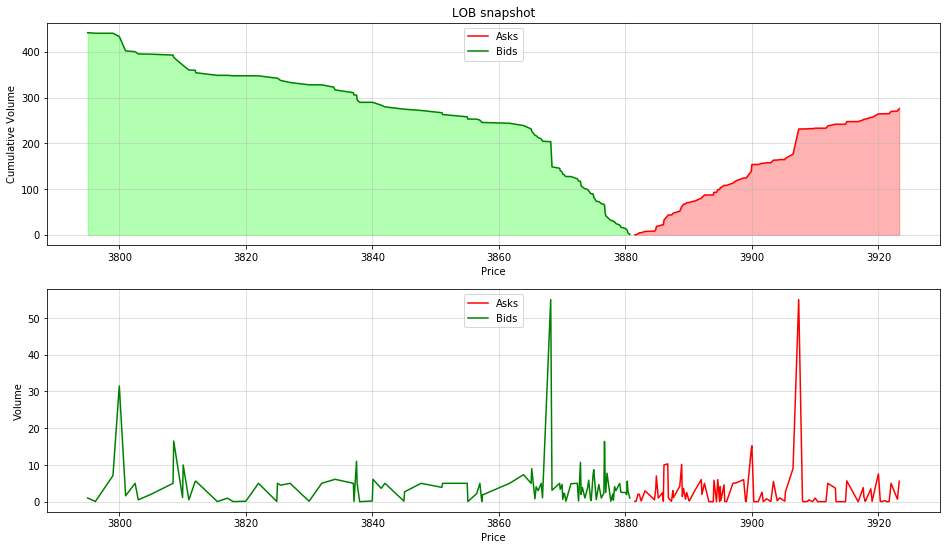

In [16]:
display_snapshot(dataset[700])

Timestamp:	 2019/03/15


,WAMP,VWAP
Open,3856.305263,3851.978706
High,3908.198237,3900.724422
Low,3848.710024,3840.458851
Close,3903.285714,3893.912015
Volatility,17.769762,17.386502


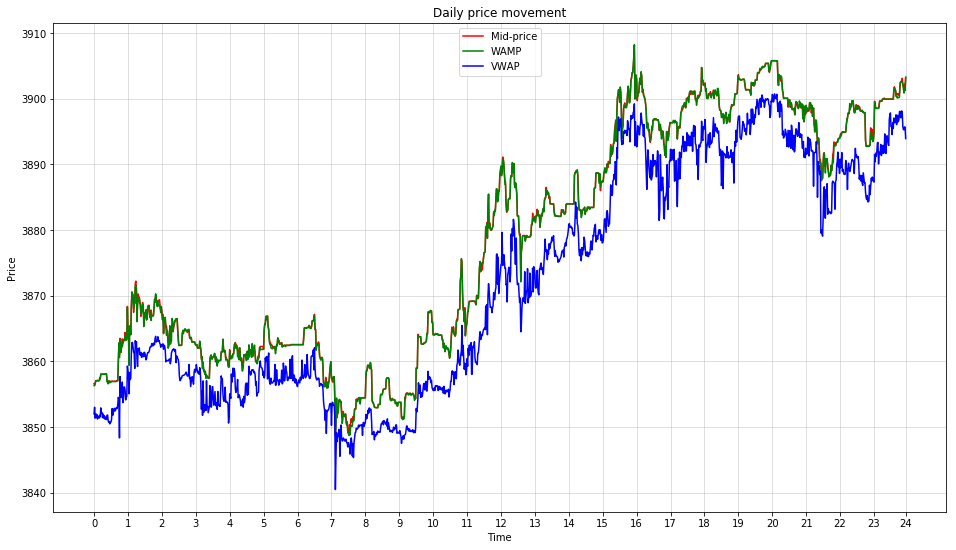

In [15]:
display_day(dataset)